In [185]:
import json 
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [186]:
#define a function to read the features
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

#define a function to read the statistical values di un df
def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

#define a function to compute the root mean square log error 
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [187]:
#description of the apartments
apartments = pd.read_csv('apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


In [188]:
#description of the buildings
buildings = pd.read_csv('buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings


Loaded 6791 buildings


,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,96,0.0,55.891077,37.651583,2.0,Широкая улица,1К5,1980.0,3.0,16.0,0.0,1.0,1.0,1.0,1.0,0.0
6787,5857,0.0,55.821755,37.652930,2.0,улица Космонавтов,5,1989.0,3.0,9.0,0.0,1.0,0.0,NaN,0.0,0.0
6788,5218,0.0,55.600694,37.366484,11.0,улица Лаптева,4,2017.0,3.0,17.0,0.0,1.0,1.0,1.0,1.0,0.0
6789,1346,0.0,55.598817,37.360196,11.0,улица Москвитина,5к1,2016.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0


In [189]:
#merge the due dataset using the building_id 
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data

All apartments have an associated building: True


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,23280,NaN,13300000.0,65.0,16.0,32.0,3.0,2.0,NaN,3.00,...,70к6,2017.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
23281,23281,3.0,15854300.0,56.9,9.6,36.5,6.0,2.0,NaN,NaN,...,2/2,2020.0,2.0,20.0,0.0,1.0,0.0,0.0,NaN,NaN
23282,23282,NaN,19800000.0,73.4,23.0,29.3,16.0,2.0,NaN,NaN,...,4,2018.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0,NaN
23283,23283,0.0,29999000.0,100.8,20.0,NaN,4.0,3.0,NaN,NaN,...,39К1,1997.0,2.0,10.0,0.0,1.0,1.0,0.0,NaN,0.0


In [190]:
#do the same process with the data_test
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.tail()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33217,3.0,106.0,19.9,56.7,16.0,3.0,NaN,3.3,NaN,...,10А,2020.0,2.0,20.0,0.0,1.0,1.0,0.0,NaN,0.0
9933,33218,NaN,82.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0,...,к1,2021.0,2.0,20.0,0.0,1.0,1.0,1.0,NaN,NaN
9934,33219,NaN,49.3,NaN,NaN,15.0,1.0,NaN,0.0,NaN,...,70к5,2016.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
9935,33220,NaN,38.8,10.5,15.1,14.0,1.0,NaN,3.3,1.0,...,1,2019.0,NaN,14.0,1.0,1.0,1.0,0.0,1.0,NaN
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
data['heating'].value_counts()



0.0    13371
1.0     1263
3.0      419
2.0       71
Name: heating, dtype: int64

In [192]:
data.dtypes

id                      int64
seller                float64
price                 float64
area_total            float64
area_kitchen          float64
area_living           float64
floor                 float64
rooms                 float64
layout                float64
ceiling               float64
bathrooms_shared      float64
bathrooms_private     float64
windows_court         float64
windows_street        float64
balconies             float64
loggias               float64
condition             float64
phones                float64
building_id             int64
new                   float64
latitude              float64
longitude             float64
district              float64
street                 object
address                object
constructed           float64
material              float64
stories               float64
elevator_without      float64
elevator_passenger    float64
elevator_service      float64
parking               float64
garbage_chute         float64
heating   

 # Duplicated values

In [193]:
#detect the possible duplicated values inside our dataset and delete them in the case (by comparing the shape before and then):

""" data.duplicated() """

' data.duplicated() '

In [194]:
""" print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape) """

#same shape --> there weren't duplicated values inside the dataset.

' print(data.shape)\ndata.drop_duplicates(inplace=True)\nprint(data.shape) '

In [195]:
data_test.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9932    False
9933    False
9934    False
9935    False
9936    False
Length: 9937, dtype: bool

In [196]:
""" print(data_test.shape)
data_test.drop_duplicates(inplace=True)
print(data_test.shape)
 """
#same shape --> there weren't duplicated values inside the dataset.

' print(data_test.shape)\ndata_test.drop_duplicates(inplace=True)\nprint(data_test.shape)\n '

In [197]:
#plot the vertical bar chart for all the numerical attributes
# data.hist(figsize=(20,20))

# outlier identification

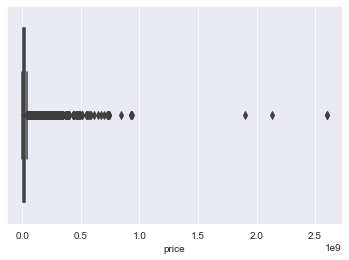

In [198]:
%matplotlib inline
import seaborn as sns

sns.boxplot(x=data['price'])

In [199]:
cols = ['price'] # one or more

Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1

data = data[~((data[cols] < (Q1 - 1.5*IQR)) |(data[cols] > (Q3 + 1.5*IQR))).any(axis=1)]

In [200]:
data = data.reset_index()
del data['index']
data

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20435,23280,NaN,13300000.0,65.0,16.0,32.0,3.0,2.0,NaN,3.00,...,70к6,2017.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
20436,23281,3.0,15854300.0,56.9,9.6,36.5,6.0,2.0,NaN,NaN,...,2/2,2020.0,2.0,20.0,0.0,1.0,0.0,0.0,NaN,NaN
20437,23282,NaN,19800000.0,73.4,23.0,29.3,16.0,2.0,NaN,NaN,...,4,2018.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0,NaN
20438,23283,0.0,29999000.0,100.8,20.0,NaN,4.0,3.0,NaN,NaN,...,39К1,1997.0,2.0,10.0,0.0,1.0,1.0,0.0,NaN,0.0


from scipy import stats

data=data[(np.abs(stats.zscore(data['price'])) < 3)]

# Missing values

In [201]:
data.isnull().sum()

id                        0
seller                 6583
price                     0
area_total                0
area_kitchen           3409
area_living            2706
floor                     0
rooms                     0
layout                15474
ceiling                9401
bathrooms_shared       3020
bathrooms_private      3020
windows_court          6988
windows_street         6988
balconies              8749
loggias                8749
condition              9083
phones                   53
building_id               0
new                     250
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             699
material               3567
stories                   0
elevator_without        335
elevator_passenger      335
elevator_service        335
parking                6278
garbage_chute          8167
heating                7267
dtype: int64

In [202]:
data_test.isnull().sum()

id                       0
seller                3942
area_total               0
area_kitchen          2233
area_living           2019
floor                    0
rooms                    0
layout                7368
ceiling               5018
bathrooms_shared      1717
bathrooms_private     1717
windows_court         3488
windows_street        3488
balconies             4835
loggias               4835
condition             3959
phones                  40
building_id              0
new                    109
latitude                 2
longitude                2
district                25
street                   0
address                  0
constructed            374
material              1671
stories                  0
elevator_without       180
elevator_passenger     180
elevator_service       180
parking               2867
garbage_chute         3426
heating               3230
dtype: int64

# DATA PREPROCESSING

In [203]:
#plot the vertical bar chart for all the numerical attributes
# data.hist(figsize=(20,20))

In [204]:
id_test=data_test['id']


In [205]:
#point 2
# id feature is pointless for the analysis of the price since it changes for each sample
del data['id']
del data_test['id']
# street and address features are pointless becuase we have latitude and longitude
del data['street']
del data_test['street']
del data['address']
del data_test['address']

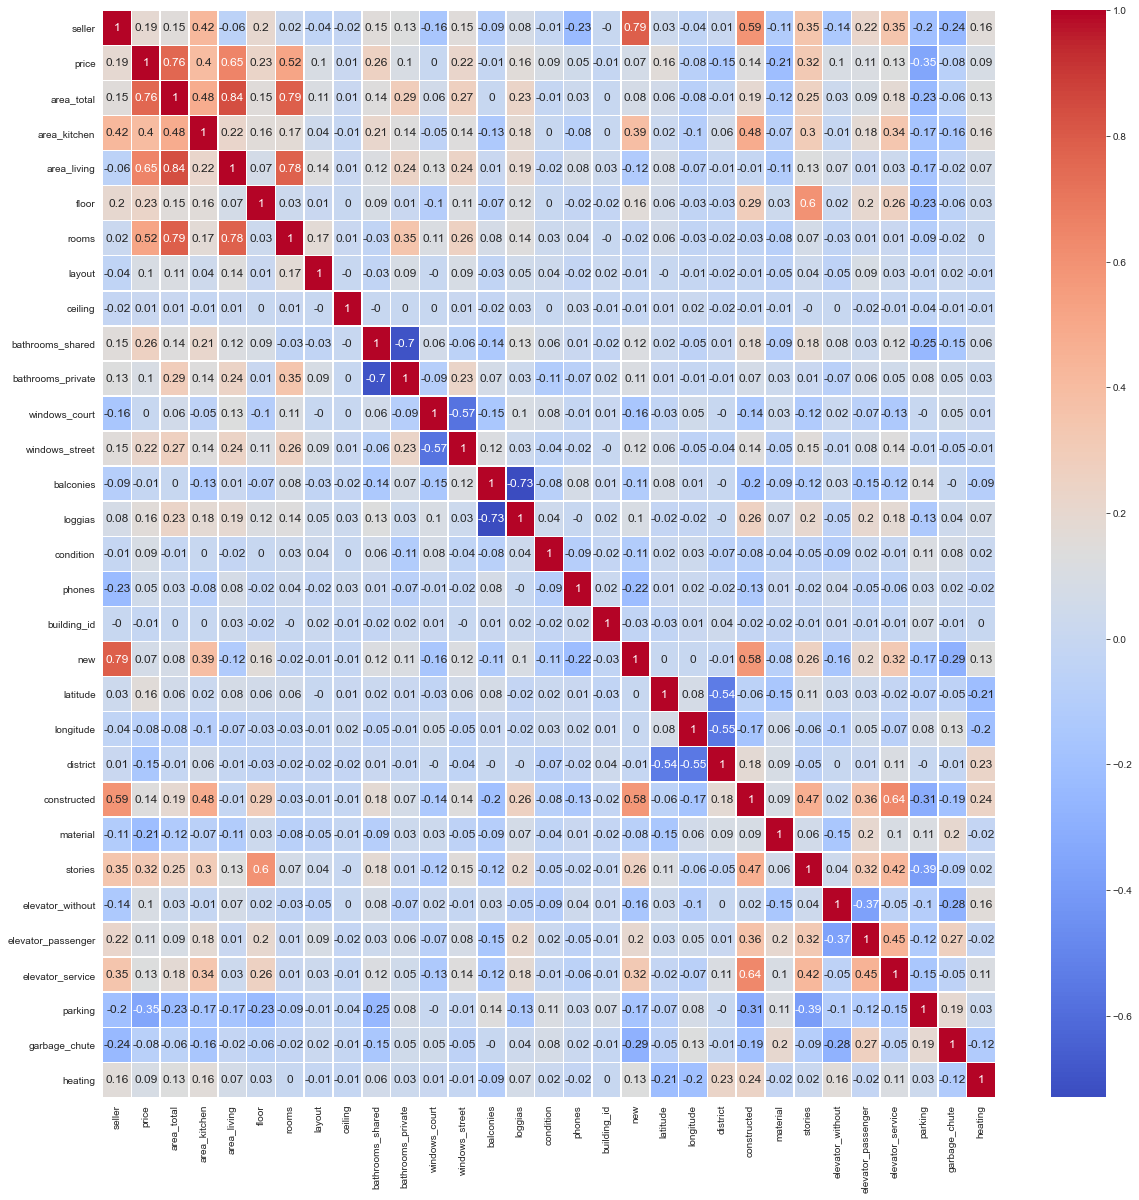

In [206]:
#heatmap
plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

In [207]:
#point 3
# layout is pointless because for the largest number of the samples this features is NaN
del data['layout']
del data_test['layout']


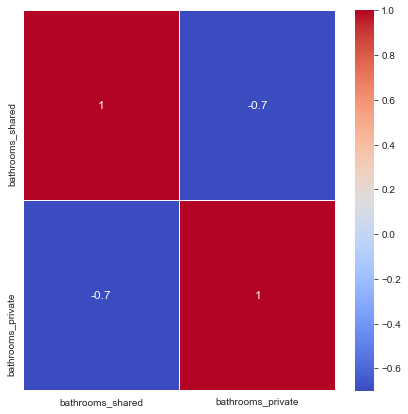

In [208]:
#point 5.a 
# firstly samples with NaN values for the features 'bathroom_shared' and 'bathroom_private' have been deleted and then the heatmap is displayed only for these two attributes
#bathroom_share is strongly correlated with bathroom_private: the coefficient is -0.61 (the correlation is inverse).
#so the feature 'bathrooms_shared' has been deleted. 
df = data[data['bathrooms_shared'].notna()]
df = df[df['bathrooms_private'].notna()]
prova=df[['bathrooms_shared','bathrooms_private']]
plt.figure(figsize = (7,7))
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()


In [209]:
del data["bathrooms_private"]
del data_test["bathrooms_private"]

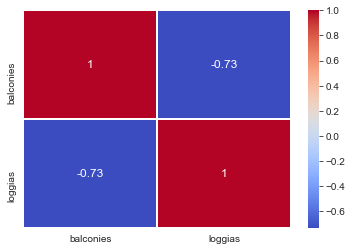

In [210]:
#point 5.b 
# firstly samples with NaN values for the features 'balconies' and 'loggias' have been deleted and then the heatmap is displayed only for these two attributes
#balconies is strongly correlated with loggias: the coefficient is -0.7(the correlation is inverse).
#so the feature 'loggias' has been deleted. 
df = data[data['balconies'].notna()]
df = df[df['loggias'].notna()]

prova=df[['balconies','loggias']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()


In [211]:
del data["loggias"]
del data_test["loggias"]


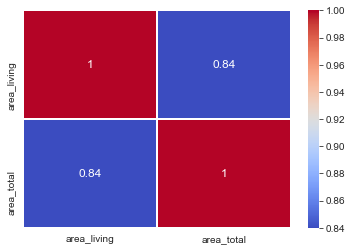

In [212]:
#point 5.c 

df = data[data['area_living'].notna()]
df = df[df['area_total'].notna()]

prova=df[['area_living','area_total']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [213]:
del data["area_living"]
del data_test["area_living"]


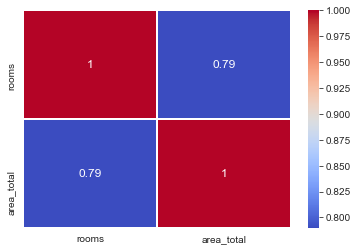

In [214]:
#point 5.d

df = data[data['rooms'].notna()]
df = df[df['area_total'].notna()]

prova=df[['rooms','area_total']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [215]:
del data["rooms"]
del data_test["rooms"]

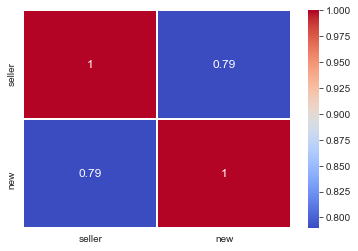

In [216]:
#point 5.e

df = data[data['seller'].notna()]
df = df[df['new'].notna()]

prova=df[['seller','new']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [217]:
del data["seller"]
del data_test["seller"]

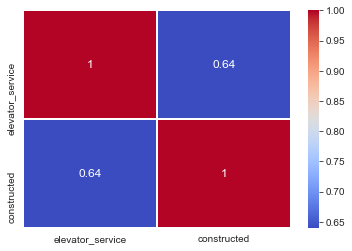

In [218]:
#point 5.f

df = data[data['elevator_service'].notna()]
df = df[df['constructed'].notna()]

prova=df[['elevator_service','constructed']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [219]:
del data["elevator_service"]
del data_test["elevator_service"]

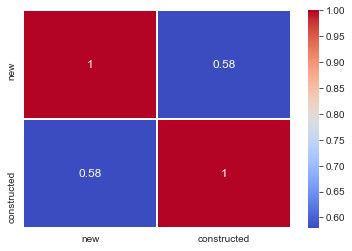

In [220]:
#point 5.g

df = data[data['new'].notna()]
df = df[df['constructed'].notna()]

prova=df[['new','constructed']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [221]:
del data["constructed"]
del data_test["constructed"]

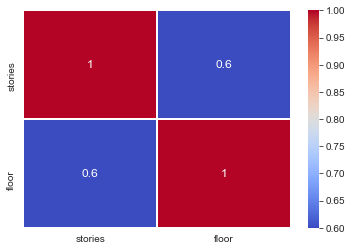

In [222]:
#point 5.h 

df = data[data['stories'].notna()]
df = df[df['floor'].notna()]

prova=df[['stories','floor']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [223]:
del data["stories"]
del data_test["stories"]

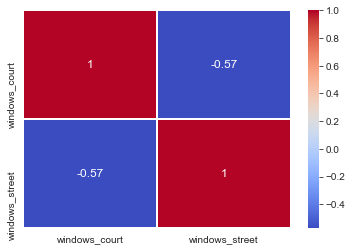

In [224]:
#point 5.i 

df = data[data['windows_court'].notna()]
df = df[df['windows_street'].notna()]

prova=df[['windows_court','windows_street']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [225]:
del data["windows_court"]
del data_test["windows_court"]

In [226]:
#point 6
# new is useless because its distribution is almost unique (boolean value = false) and it is not correlated with the price feature
del data['new']
del data_test['new']

In [227]:
#point 7

data['heating']=data['heating'].fillna(0.0)
data_test['heating']=data_test['heating'].fillna(0.0)

In [228]:
#point 8,9
data = data[data['phones'].notna()]
data = data[data['elevator_passenger'].notna()]
data_test['phones'].fillna((data_test['phones'].mean()), inplace=True)
data_test['elevator_passenger']=data_test['elevator_passenger'].fillna(1.0)

In [229]:
#data = data[data['area_kitchen'].notna()]
#data_test['area_kitchen'].fillna((data_test['area_kitchen'].mean()), inplace=True)

In [230]:
#point 10

data = data[data['district'].notna()]
data_test['district']=data_test['district'].fillna(4.0)

In [231]:
# point 11
#ceiling
elencobuilding = data['building_id'].unique().tolist()
for column in elencobuilding:
    dd = data.loc[data['building_id'] == column]['ceiling']
    if dd.sum(axis = 0) - dd.isnull().sum(axis = 0)>0:
        data.loc[data['building_id'] == column]['ceiling'].fillna(data.loc[data['building_id'] == column]['ceiling'].mode()[0])

data['ceiling'].fillna((data['ceiling'].mean()), inplace=True)

In [232]:
#point 12

del data["material"]
del data_test["material"]

In [233]:
#point 13

data['parking']=data['parking'].fillna(3.0)
data_test['parking']=data_test['parking'].fillna(3.0)

#point 14

data['bathrooms_shared'].fillna((data['bathrooms_shared'].mean()), inplace=True)
data_test['bathrooms_shared'].fillna((data_test['bathrooms_shared'].mean()), inplace=True)

In [234]:
data.dtypes

price                 float64
area_total            float64
area_kitchen          float64
floor                 float64
ceiling               float64
bathrooms_shared      float64
windows_street        float64
balconies             float64
condition             float64
phones                float64
building_id             int64
latitude              float64
longitude             float64
district              float64
elevator_without      float64
elevator_passenger    float64
parking               float64
garbage_chute         float64
heating               float64
dtype: object

In [235]:
#point 15

data['elevator_passenger']=data['elevator_passenger'].fillna(-1.0)
data_test['elevator_passenger']=data_test['elevator_passenger'].fillna(-1.0)
data['elevator_without']=data['elevator_without'].fillna(-1.0)
data_test['elevator_without']=data_test['elevator_without'].fillna(-1.0)
data['garbage_chute']=data['garbage_chute'].fillna(-1.0)
data_test['garbage_chute']=data_test['garbage_chute'].fillna(-1.0)
data['windows_street']=data['windows_street'].fillna(-1.0)
data_test['windows_street']=data_test['windows_street'].fillna(-1.0)

In [236]:
print(data_test.groupby('longitude').size())

longitude
-61.790500      4
 36.865036      6
 36.865143      1
 36.865826      3
 36.869905      6
               ..
 37.948000      4
 37.949626     19
 74.517184      1
 132.759204     1
 132.768097     1
Length: 2777, dtype: int64


In [237]:
#point 16

data_test['longitude'].fillna((data_test['longitude'].mean()), inplace=True)
data_test['latitude'].fillna((data_test['latitude'].mean()), inplace=True)


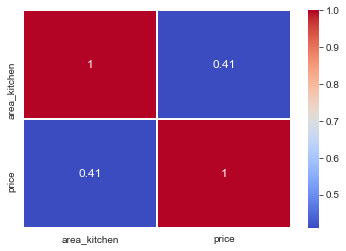

In [238]:
prova=data[['area_kitchen','price']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

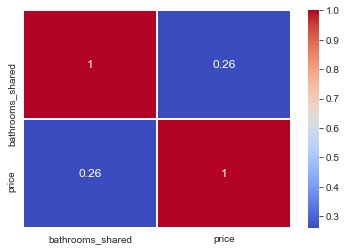

In [239]:
prova=data[['bathrooms_shared','price']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

#point 17

#I created a new df with just the feature where I want to fill in the NaN (area_kitchen) and the feature highly correlated with 
#it because I  want to use just that to apply the k-means. Then I have to replace the original column 'area_kitchen' with the new one

data1=data[['area_kitchen','area_total']]
data_test1=data_test[['area_kitchen','area_total']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=10)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_kitchen','area_total'])))])


data1=imputer.fit_transform(data1)
data_test1=imputer.fit_transform(data_test1)


x1=data1['area_kitchen']
x1 = x1.reset_index()
data = data.reset_index()
data['area_kitchen'] = x1

x2=data_test1['area_kitchen']
x2 = x2.reset_index()
data_test = data_test.reset_index()
data_test['area_kitchen'] = x2

del data['index']
del data_test['index']

In [240]:
col1 = data['bathrooms_shared']
col2 = data_test['bathrooms_shared']
#col3 = data['area_kitchen']
#col4 = data_test['area_kitchen']

In [241]:
#I have to use a pipeline because otherwise I obtain an array and not a dataframe (I tried to transform the array in a df again,
#but in that case I obtain again the NaN, they are not transformed)

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=10)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['price','area_total','area_kitchen','floor','ceiling','bathrooms_shared','windows_street','balconies','condition','phones','building_id','latitude','longitude','district','elevator_without','elevator_passenger','parking','garbage_chute','heating'])))])

imputer2 = Pipeline([("imputer", KNNImputer(n_neighbors=10)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_total','area_kitchen','floor','ceiling','bathrooms_shared','windows_street','balconies','condition','phones','building_id','latitude','longitude','district','elevator_without','elevator_passenger','parking','garbage_chute','heating'])))])

data=imputer.fit_transform(data)
data_test=imputer2.fit_transform(data_test)

In [242]:
data['bathrooms_shared'] = col1
data_test['bathrooms_shared'] = col2
#data['area_kitchen'] = col3
#data_test['area_kitchen'] = col4

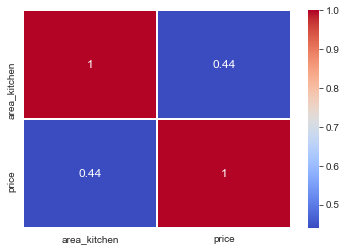

In [243]:
prova=data[['area_kitchen','price']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

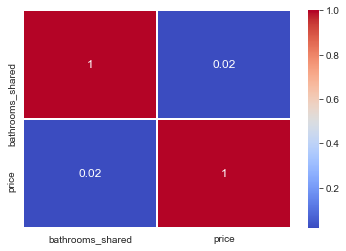

In [244]:
prova=data[['bathrooms_shared','price']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [245]:
data.isnull().sum()

price                    0
area_total               0
area_kitchen             0
floor                    0
ceiling                  0
bathrooms_shared      3159
windows_street           0
balconies                0
condition                0
phones                   0
building_id              0
latitude                 0
longitude                0
district                 0
elevator_without         0
elevator_passenger       0
parking                  0
garbage_chute            0
heating                  0
dtype: int64

In [61]:
# #before merge the deleted columns into our dataset, it's necessary to apply a reset of the index because they didn't match each
# #other (the last of the data is 22736, while the last of the new vectors is 23283)

# data=data.reset_index(drop=True)

In [62]:
data.dtypes

price                 float64
area_total            float64
area_kitchen          float64
floor                 float64
ceiling               float64
bathrooms_shared      float64
windows_street        float64
balconies             float64
condition             float64
phones                float64
building_id           float64
latitude              float64
longitude             float64
district              float64
elevator_without      float64
elevator_passenger    float64
parking               float64
garbage_chute         float64
heating               float64
dtype: object

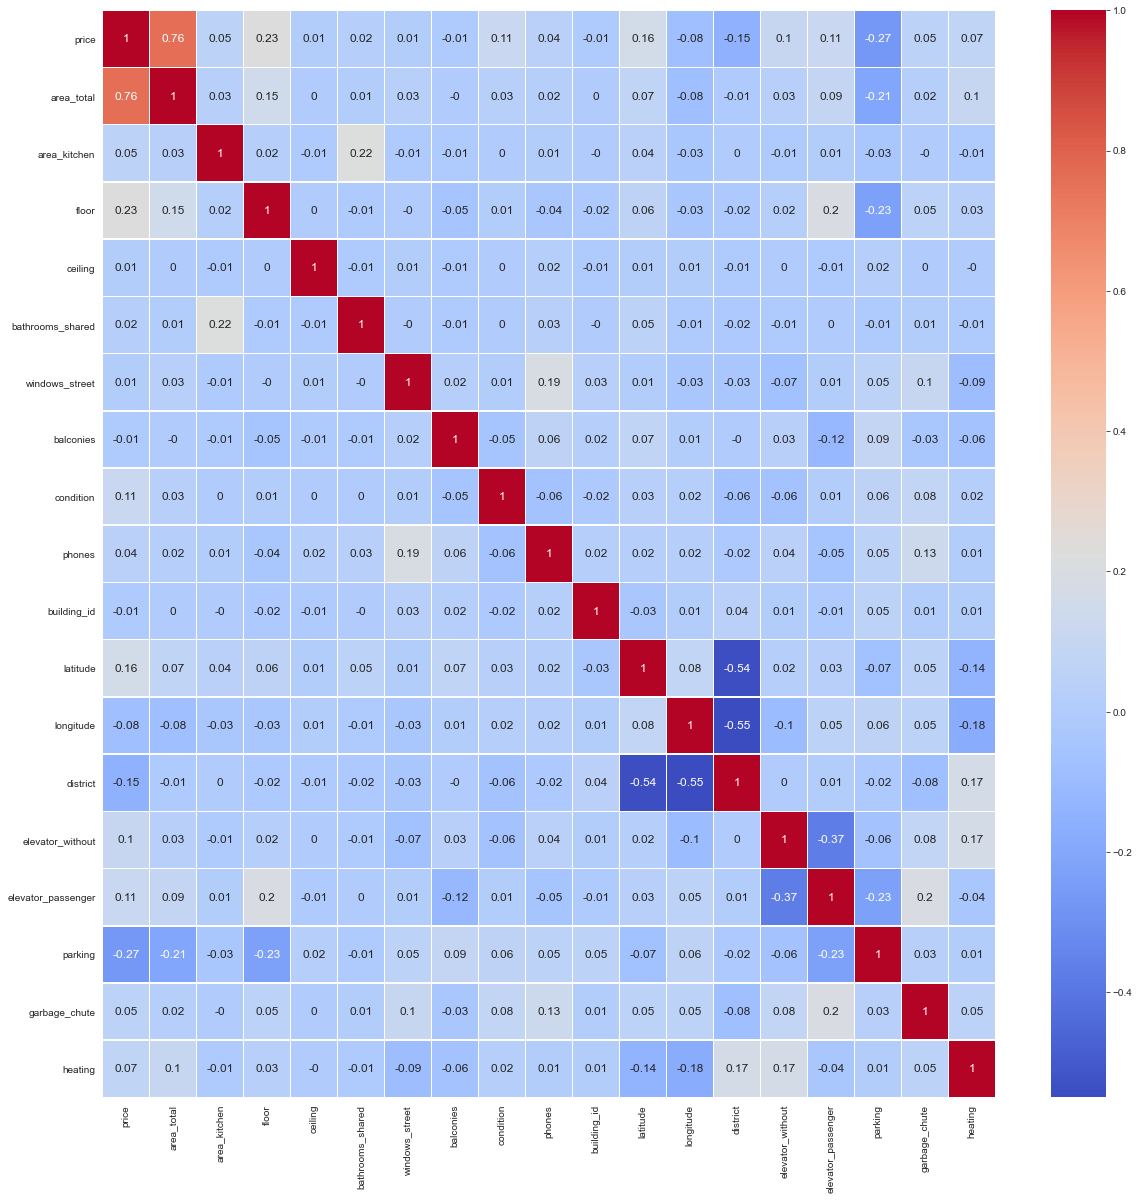

In [63]:
plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

In [64]:
from impyute.imputation.cs import mice
import impyute as impy
# start the MICE training
data1 = data
data1 = impy.mice(data1.to_numpy())
data1.shape
data['bathrooms_shared'] = data1[:, 5]
data['area_kitchen'] = data1[:, 5]

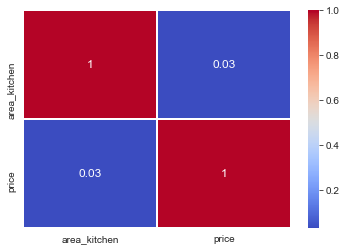

In [65]:
prova=data[['area_kitchen','price']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

# Transformation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E209311B50>,
      dtype=object)

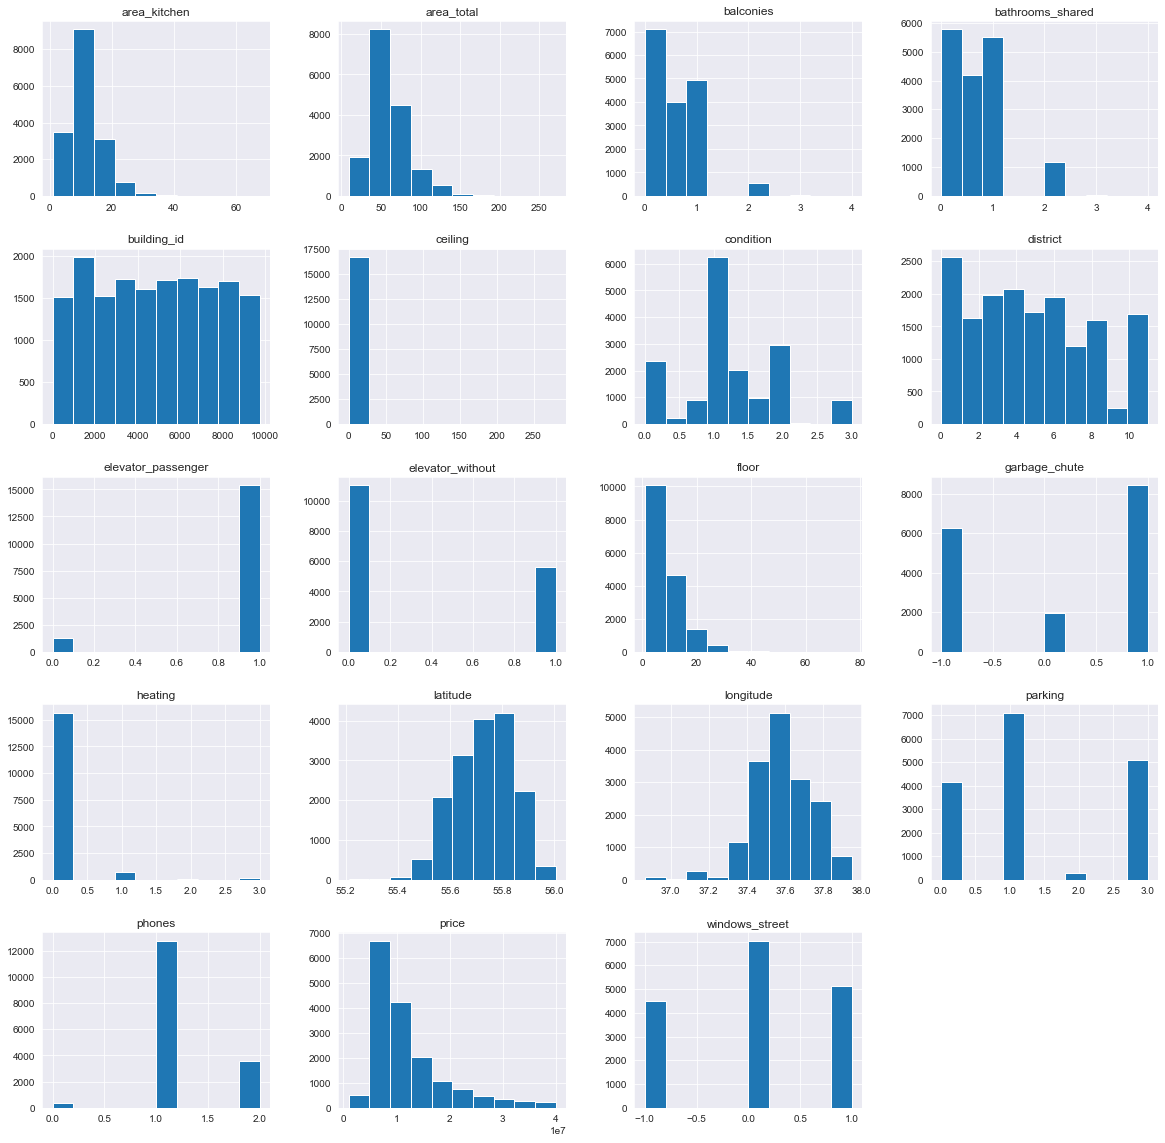

In [891]:
#first I have to analyze the distribution of the (numerical) features

data.hist(figsize=(20,20))

In [892]:
#I can apply a log transformation to the feature 'area_total'. I'd like to do it also for the feature 'ceiling', but it contain
#the value 0 (you can't apply the log with it) and if you try to replace 0=0.001 the resulting log transformation isn't good

data['area_total']=data['area_total'].apply(math.log)
data_test['area_total']=data_test['area_total'].apply(math.log)

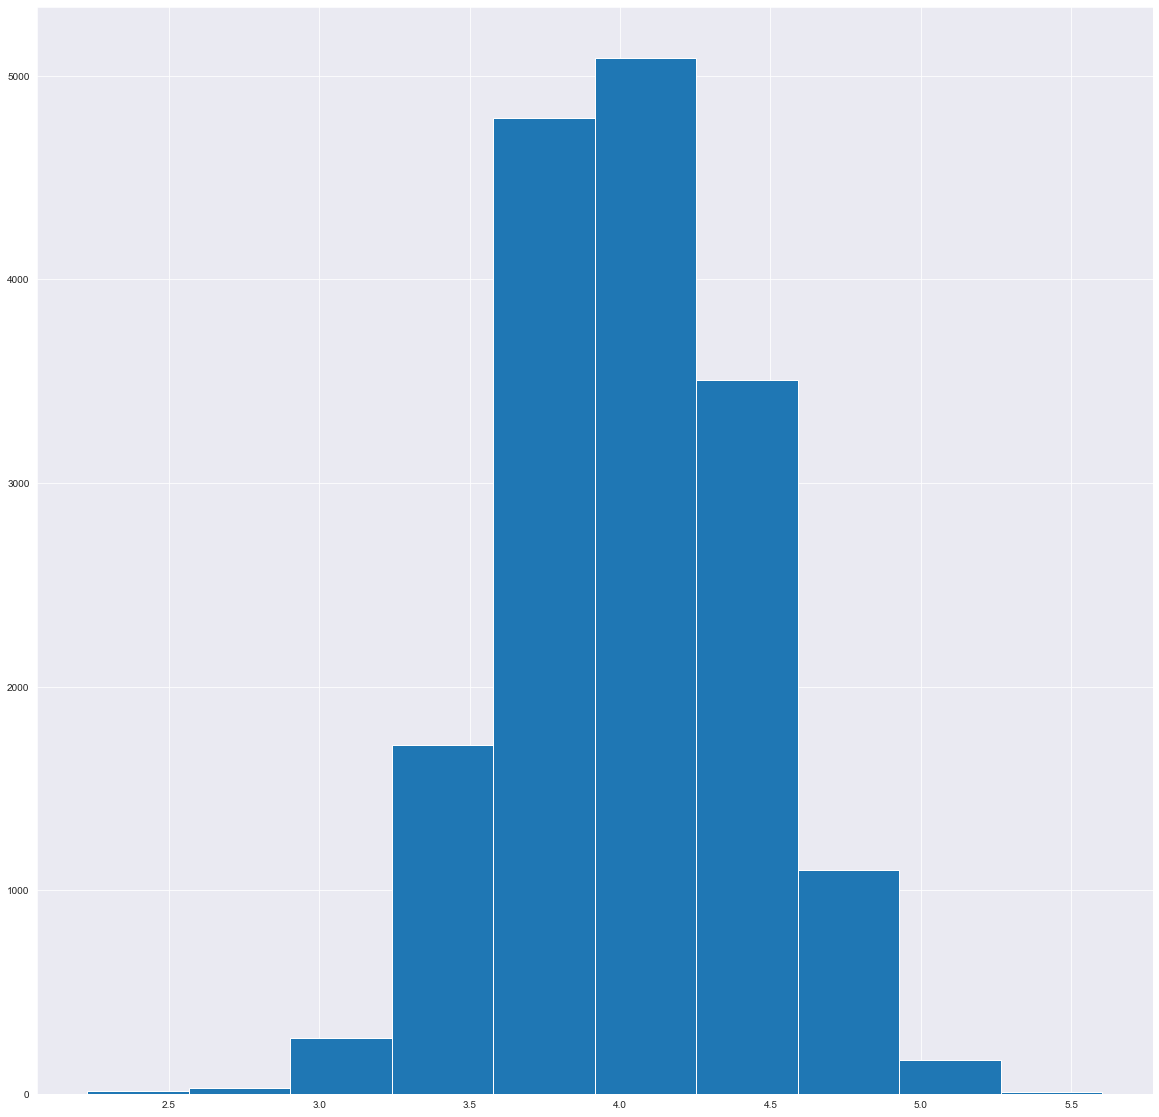

In [893]:
data['area_total'].hist(figsize=(20,20))

# DUMMIES for categorical features

In [894]:
# #transform the categorical attributes (street and address) into dummies 

# dummies = pd.get_dummies(df_categorical.astype(str),drop_first=True) 
# dummies2 = pd.get_dummies(df_categorical2.astype(str),drop_first=True) 

In [895]:
# dummies.shape

In [896]:
# X=pd.concat([dummies,X_numerical], axis = 1)
# X2=pd.concat([dummies2,X_numerical2], axis = 1)

In [897]:
# X2.shape

# PCA

(I'm not sure PCA is the best option here)

#PCA fit
from sklearn.decomposition import PCA
# we can choose the number of components e.g. 10, the percentage of the total variance or set it to None (that means it automatically chooses the number of components)
pca2 = PCA(n_components=6)

pca2.fit(X) #The fit learns some quantities from the data, most importantly the "components" and "explained variance"
X = pd.DataFrame(pca2.transform(X))

explained_var=pd.DataFrame(pca2.explained_variance_ratio_).transpose()
%matplotlib inline
ax = sns.barplot( data=explained_var)#i primi due mi danno gia più del 75% di informazioni

cum_explained_var=np.cumsum(pca2.explained_variance_ratio_)
pd.DataFrame(cum_explained_var).transpose()

pca2.fit(X2)
X2 = pd.DataFrame(pca2.transform(X2))

cum_explained_var=np.cumsum(pca2.explained_variance_ratio_)
pd.DataFrame(cum_explained_var).transpose()

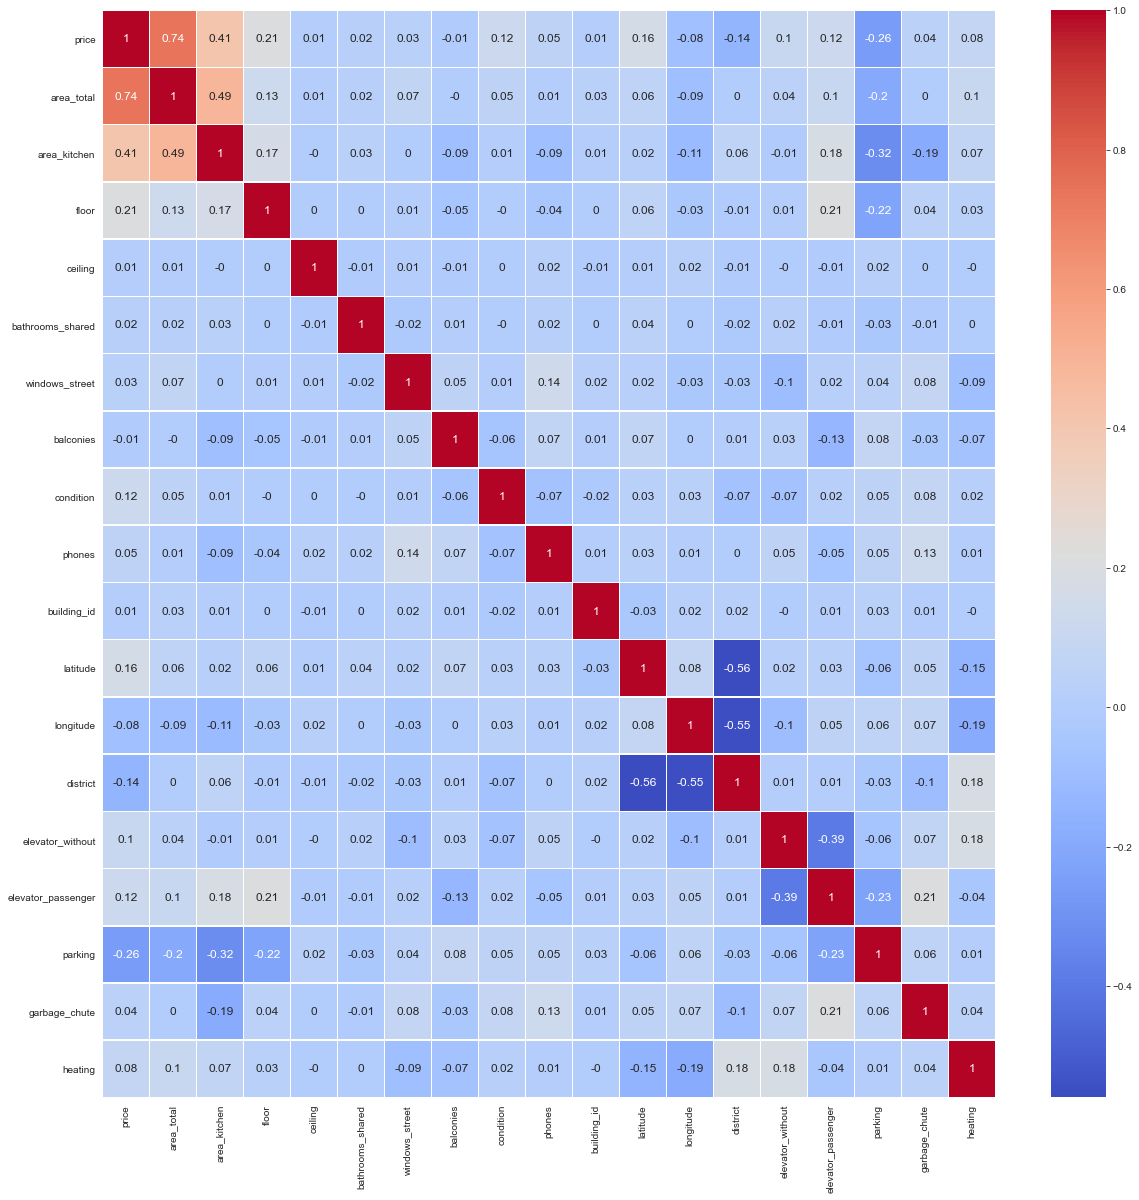

In [899]:
plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

In [900]:
data.shape

(16681, 19)

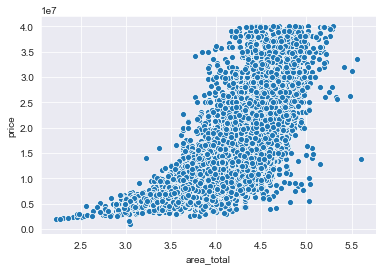

In [901]:
sns.scatterplot(x=data['area_total'],y=data['price'])

In [902]:
data = data.drop(data[(data['price'] > 800000000)].index)

In [903]:
data = data.drop(data[(data['price'] < 1600000)].index)

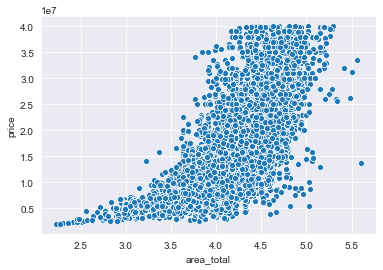

In [904]:
sns.scatterplot(x=data['area_total'],y=data['price'])

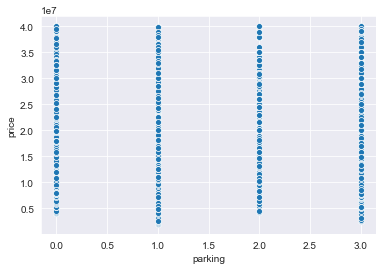

In [905]:
sns.scatterplot(x=data['parking'],y=data['price'])

In [906]:
data = data.drop(data[(data['price'] > 600000000) & (data['parking']==1.0)].index)

In [907]:
data = data.drop(data[(data['price'] > 500000000) & (data['parking']==2.0)].index)

In [908]:
data = data.drop(data[(data['price'] > 400000000) & (data['parking']==3.0)].index)

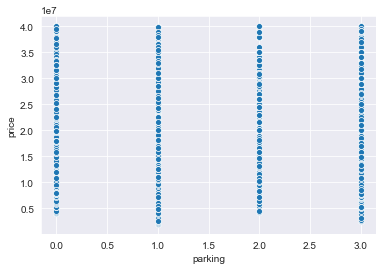

In [909]:
sns.scatterplot(x=data['parking'],y=data['price'])

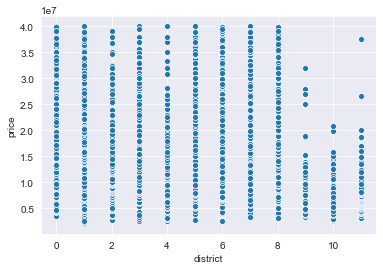

In [910]:
sns.scatterplot(x=data['district'],y=data['price'])

In [911]:
data = data.drop(data[(data['price'] > 400000000) & (data['district']==8.0)].index)
data = data.drop(data[(data['price'] > 100000000) & (data['district']==3.0)].index)
data = data.drop(data[(data['price'] > 100000000) & (data['district']==4.0)].index)

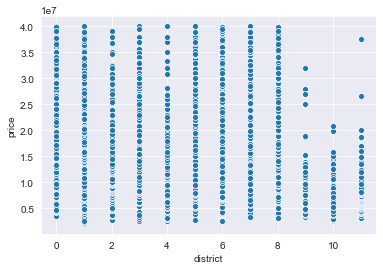

In [912]:
sns.scatterplot(x=data['district'],y=data['price'])

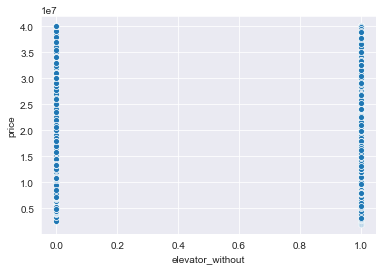

In [913]:
sns.scatterplot(x=data['elevator_without'],y=data['price'])

In [914]:
data[(data['elevator_without']==0) & (data['price']>420000000)].count()

price                 0
area_total            0
area_kitchen          0
floor                 0
ceiling               0
bathrooms_shared      0
windows_street        0
balconies             0
condition             0
phones                0
building_id           0
latitude              0
longitude             0
district              0
elevator_without      0
elevator_passenger    0
parking               0
garbage_chute         0
heating               0
dtype: int64

In [915]:
data = data.drop(data[(data['price'] > 420000000) & (data['elevator_without']==0.0)].index)

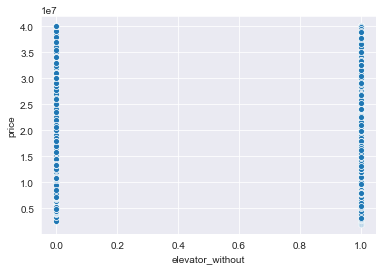

In [916]:
sns.scatterplot(x=data['elevator_without'],y=data['price'])

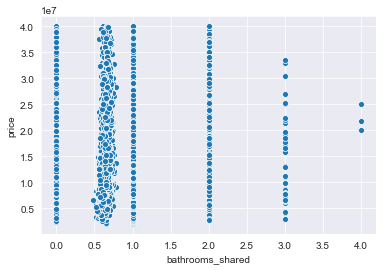

In [917]:
sns.scatterplot(x=data['bathrooms_shared'],y=data['price'])

In [918]:
data = data.drop(data[(data['bathrooms_shared']==4.0)].index)

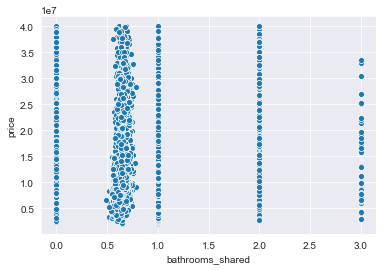

In [919]:
sns.scatterplot(x=data['bathrooms_shared'],y=data['price'])

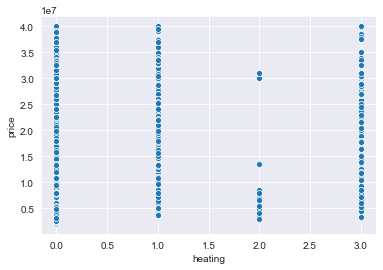

In [920]:
sns.scatterplot(x=data['heating'],y=data['price'])

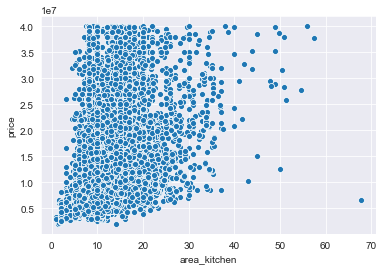

In [921]:
sns.scatterplot(x=data['area_kitchen'],y=data['price'])

In [922]:
data[(data['heating']==0.0) & (data['price']>550000000)].count()

price                 0
area_total            0
area_kitchen          0
floor                 0
ceiling               0
bathrooms_shared      0
windows_street        0
balconies             0
condition             0
phones                0
building_id           0
latitude              0
longitude             0
district              0
elevator_without      0
elevator_passenger    0
parking               0
garbage_chute         0
heating               0
dtype: int64

In [923]:
data = data.drop(data[(data['price'] > 550000000) & (data['heating']==0.0)].index)
data = data.drop(data[(data['price'] > 400000000) & (data['heating']==3.0)].index)


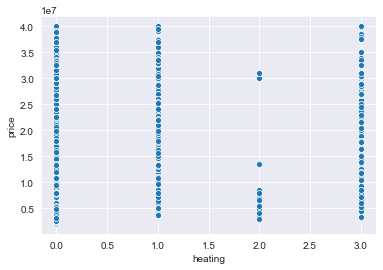

In [924]:
sns.scatterplot(x=data['heating'],y=data['price'])

In [925]:
data.shape

(16676, 19)

# standardization

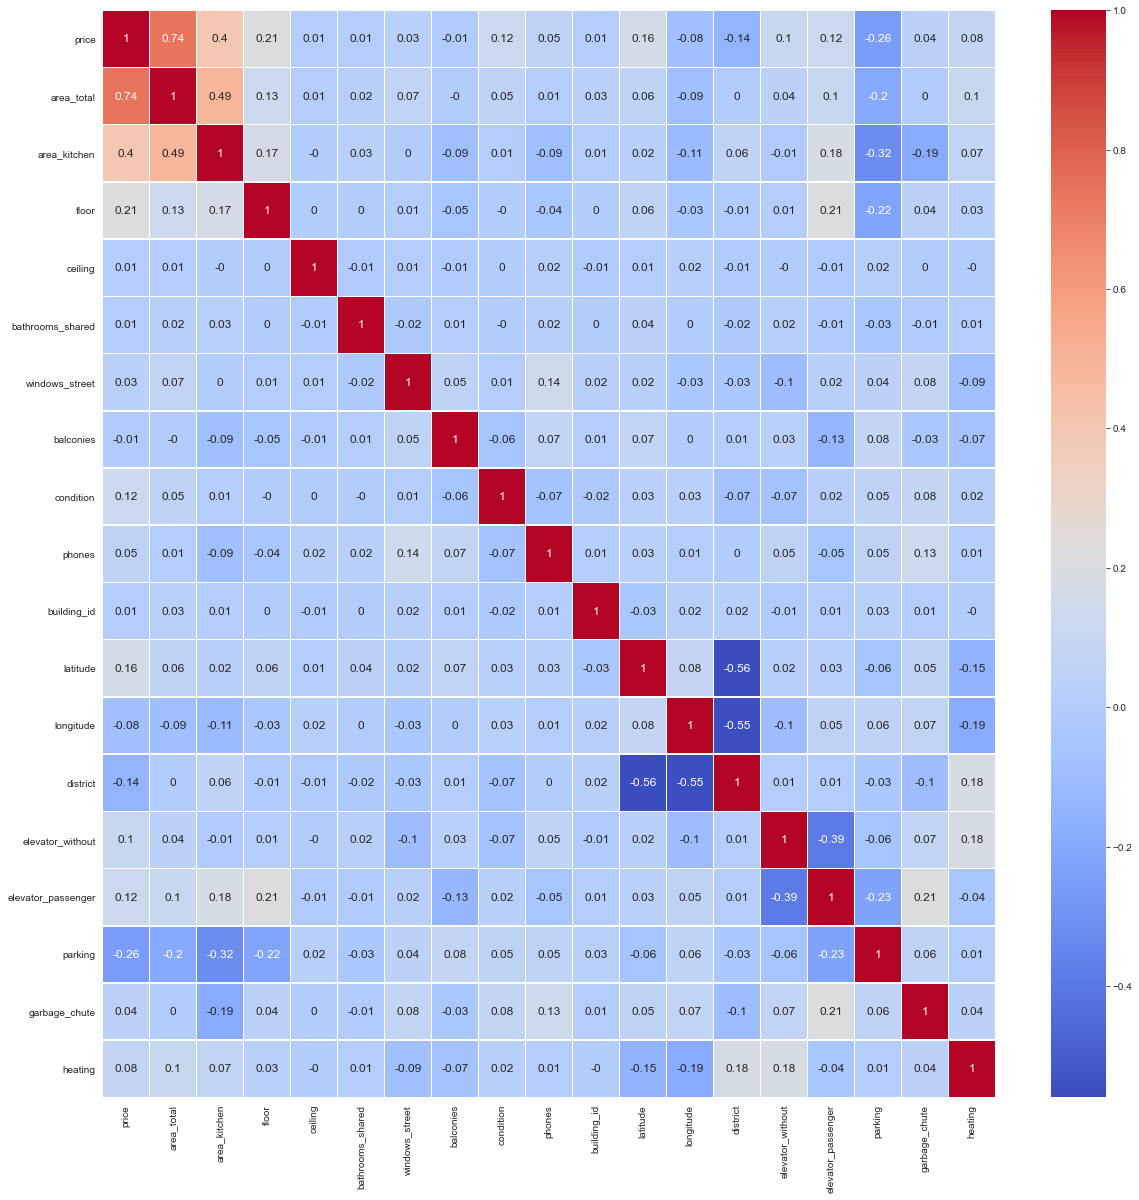

In [927]:
plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

In [928]:
#before standardize I have to save the feature 'price' in another array and delete it from the df

y=data['price']
del data['price']
data=data[['floor','area_total','parking','bathrooms_shared','district','elevator_passenger','area_kitchen']]
data_test=data_test[['floor','area_total','parking','bathrooms_shared','district','elevator_passenger','area_kitchen']]

#del data['building_id']
#del data_test['building_id']

In [929]:
#standardization of all the numerical attributes remained

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data)
scaled_df = pd.DataFrame(scaler.transform(data))
scaled_df.columns = data.columns

scaler = StandardScaler().fit(data_test)
scaled_df2 = pd.DataFrame(scaler.transform(data_test))
scaled_df2.columns = data_test.columns


In [930]:
data=scaled_df.iloc[:,:]
data_test=scaled_df2.iloc[:,:]
data['price']=y

# separation of target class and indipendent features

def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])


data.apply(minMax)



In [931]:
data = data.reset_index()
del data['index']
del data['price']

In [932]:
X=data
X.shape

(16676, 7)

In [933]:
X.isnull().sum()

floor                 0
area_total            0
parking               0
bathrooms_shared      0
district              0
elevator_passenger    0
area_kitchen          0
dtype: int64

# Separate Train/Test sets

In [934]:
#after importing the necessary library, we can do the splitting between the training and test set, with a percentege of the 
#training equal to 70% of the starting dataset. Moreover, it has been fixed the random seed for replicability by putting the 
#parameter random_state= 123.

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.33, #by default is 75%-25%
                                                    random_state= 123) #fix random seed for replicability

print(X_train.shape, X_test.shape)

(11172, 7) (5504, 7)


In [935]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor() # base_estimator=DecisionTreeRegressor(max_depth=3)
parameters = {"n_estimators":[50,100,150,200,250,300], "learning_rate":[0.1,0.5,1], 
              "loss": ['ls'], "random_state" : [0] ,
             "max_depth":[1,2]}

# #DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=10) 

gs = gs.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test, y_test)

***GRIDSEARCH RESULTS***
Best score: 0.791951 using {'learning_rate': 0.5, 'loss': 'ls', 'max_depth': 2, 'n_estimators': 300, 'random_state': 0}
0.684042 (0.014852) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'n_estimators': 50, 'random_state': 0}
0.722554 (0.016528) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}
0.733402 (0.017325) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'n_estimators': 150, 'random_state': 0}
0.738050 (0.017684) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'n_estimators': 200, 'random_state': 0}
0.740567 (0.017881) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'n_estimators': 250, 'random_state': 0}
0.742212 (0.017822) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'n_estimators': 300, 'random_state': 0}
0.745729 (0.015568) with: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
0.767915 (0.017646) with

0.796877177258456

In [936]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",np.sqrt(metrics.r2_score(y_test, gs.predict(X_test))))

MAE train:  1930087.7156660205
MSE train:  8636245805238.256
RMSE train:  2938749.0204572175
r2:  0.9165803141758333
MAE test:  2077464.9883578115
MSE test:  10265952035665.637
RMSE test:  3204052.4395935903
r2:  0.8926797730756847


#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID
from sklearn.svm import SVR
import numpy as np

regressor = SVR()
parameters = {'C': [0.1,10,100],
             'epsilon': [0.01,0.1,1],
             'gamma':['auto','scale'],
             'kernel': ['linear','poly','rbf'],
             'degree': [2,3,4]
             }

#DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=10, verbose = 10) #with no params it reduces to a CV

gs = gs.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test, y_test)

In [108]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",np.sqrt(metrics.r2_score(y_test, gs.predict(X_test))))

MAE train:  2248901.258617457
MSE train:  11472991590319.574
RMSE train:  3387180.477966826
r2:  0.9013232274707634
MAE test:  2445707.326012809
MSE test:  13701969837041.502
RMSE test:  3701617.1921258285
r2:  0.8776202649899835


In [109]:
model=GradientBoostingRegressor(learning_rate=0.5, loss='ls', max_depth=2, n_estimators=100, random_state=0)

In [110]:
X2=data_test
model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.5, max_depth=2, random_state=0)

In [111]:
list(set(X2) - set(X))

[]

In [112]:
X2=X2[X.columns]

In [113]:
y_pred2= model.predict(X2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
X2['target']=y_pred2

print(X2.groupby('target').size())

In [ ]:
X2.columns

In [ ]:
predictions=pd.DataFrame()

predictions['id']=id_test
predictions['price_prediction']=y_pred2

predictions.to_csv('predictions.csv', index=False)

from xgboost import XGBRegressor
model = XGBRegressor()
parameters={'n_estimators':[2,10,50,100,300]}
model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

# #DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, parameters, cv=3) 

gs = gs.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test, y_test)

list(set(X2) - set(X))
X2=X2[X.columns]
y_pred2= model.predict(X2)
X2['target']=y_pred2

print(X2.groupby('target').size())
X2.columns

import sklearn.metrics as metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",np.sqrt(metrics.r2_score(y_test, gs.predict(X_test))))

predictions=pd.DataFrame()

predictions['id']=id_test
predictions['price_prediction']=y_pred2

predictions.to_csv('predictions.csv', index=False)